In [1]:
import numpy as np
import scipy 
from scipy import stats
from scipy.stats import norm,uniform
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LinearRegression
import math
import pdb
import pandas as pd

In [2]:
Power = np.array([36.63, 38.26, 39.39, 40.56, 43.23, 56.54, 72.70, 84.19, 76.06, 61.32, 50.75, 46.90])
Gas = np.array([2.905, 2.81, 2.76, 2.73, 3.20, 3.88, 4.45, 4.8, 4.56, 4.13, 3.68, 3.49])
PowerTheta = np.array([40, 39.5 ,42. , 43. , 40. , 85.5 ,85. , 96.,  65. , 33.5 ,32.5 ,54.])
GasTheta = np.array([2.55 ,2.8 , 2.65 , 2.15, 5.65 , 5.2  , 6.25 ,7.3 , 2.55, 2.55 ,2.4 , 2.05])


# Simulate Prices

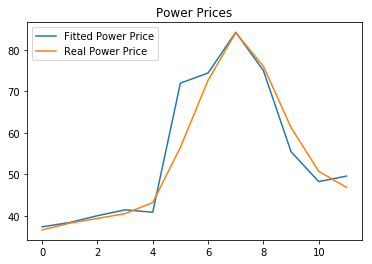

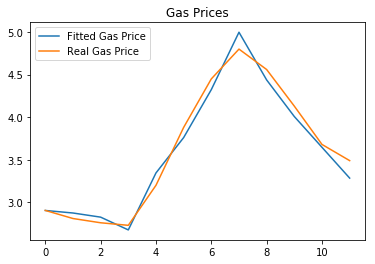

In [4]:
def SimulatePrices(N = 24,    #N is the number of months
    PowerPrices = Power, 
    GasPrices = Gas,
    thetap1= PowerTheta,
    thetag1 = GasTheta,
    rho = 0.3,   
    n = 10000 ,
    dt = 1/48,
    random_seed = 100,
    plot_choice = 0): #number of paths
    
    #params
    N_month = N
    N *= 4
    month_list = [i for i in range(1,13)]
    alphaCC,alphaJC,alphaG = 7, 20, 3
    m = 75
    p = 0.083 # lambda*dt, weekly probability
    CC0,JC0, G0 = 35, 0, 3
    spike_thres = 75
    sigmaG = 7.22/np.sqrt(dt)/100
    
    #V summer and winter
    v_summer = 28.87/np.sqrt(dt)/100
    v_winter = 10.83/np.sqrt(dt)/100
    V = np.zeros((N+1,n))
    
    W = norm.rvs(size = (N+1,n))*np.sqrt(dt)
    Wtilde = norm.rvs(size = (N+1,n))*np.sqrt(dt)
    B = rho*W + np.sqrt(1-rho**2)*Wtilde
    
    # 0 ~N, 0 is December, 1 is January
    CC = np.zeros((N+1,n)) 
    CC[0,:] = CC0
    JC = np.zeros((N+1,n))
    JC[0,:] = JC0
    G = np.zeros((N+1,n)) 
    G[0,:] = G0
    PC = np.zeros((N+1,n))
    PC[0,:] = CC[0,:]
    # 
    Power_Price_Fit, Gas_Price_Fit, CC_Price_Fit, JC_Price_Fit = list(), list(), list(), list()
    compare_Power_Price_Fit,compare_Gas_Price_Fit = list(),list()

    
    for i in range(1, N + 1):
        month1 = month_list[int(np.ceil(i/4)) - 1] if int(np.ceil(i/4)) <= 12 else month_list[int(np.ceil(i/4)) - 13]
        monthIndicator = (month1 > 4)&(month1 < 9)

        V[i,:] = monthIndicator*v_summer + (1 - monthIndicator)*v_winter
        CC[i,:] = alphaCC*(thetap1[month1-1] - CC[i-1,:])*dt + V[i,:]*CC[i-1,:]*W[i,:] + CC[i-1,:]
        JC[i,:] = alphaJC*( 0 - JC[i-1,:])*dt + m*(uniform.rvs() < p)+JC[i-1,:]
        #Power Price
        PC[i,:] = CC[i,:] + JC[i,:]*(PC[i-1,:] > spike_thres)
        #Gas Price
        G[i,:]  = alphaG*(thetag1[month1-1] - G[i-1,:])*dt + sigmaG * G[i-1,:] * B[i,:] + G[i-1,:]

        Power_Price_Fit.append(np.mean(PC[i,:]))
        Gas_Price_Fit.append(np.mean(G[i,:]))
        CC_Price_Fit.append(np.mean(CC[i,:]))
        JC_Price_Fit.append(np.mean(JC[i,:]))
        
        if i%4 == 0 and np.ceil(i/4) <= 12:
            compare_Power_Price_Fit.append(np.mean(PC[i,:]))
            compare_Gas_Price_Fit.append(np.mean(G[i,:]))
        
    if plot_choice == 1:
        fig = plt.figure()
        plt.plot(compare_Power_Price_Fit,label = 'Fitted Power Price')
        plt.plot(Power, label = 'Real Power Price')
        plt.title('Power Prices')
        plt.legend()
        
        fig = plt.figure()
        plt.plot(compare_Gas_Price_Fit,label = 'Fitted Gas Price')
        plt.plot(Gas,label = 'Real Gas Price')
        plt.title('Gas Prices')
        plt.legend()
        
    #np.savetxt('Power_Simulation_97.csv',PC[:,:] , delimiter=",")
    #np.savetxt('Gas_Simulation_97.csv',G[:,:],delimiter=",")
    return PC[1:,:],G[1:,:]
    
np.random.seed(100)
sim_power, sim_gas = SimulatePrices(plot_choice = 1)
SS = (sim_power - 12*sim_gas)*1000 * 16 * 7.6


# Constant Threshold Optimization 

28.95911771372813

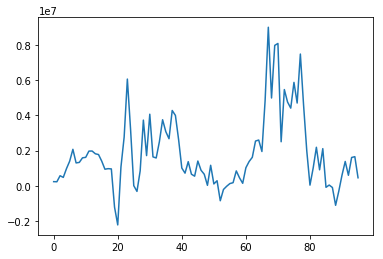

In [9]:
def L0(x):
    return np.exp(-x/2)
def L1(x):
    return np.exp(-x/2)*(1-x)
def L2(x):
    return np.exp(-x/2)*(1-2*x+x**2/2)
def R(ss_t):
    return ss_t - 5 * 1000 * 16 * 7.6

def f(s_t,a_t,ss_t,L,U):

    start_cost = 3 * 1000 * 16 * 7.6
    
    I_00 = (s_t == 0)&(a_t == 0)
    I_01 = (s_t == 0)&(a_t == 1)
    I_1 = (s_t == 1)
    
    result = np.zeros(1)
    
    result[I_00] = 0
    result[I_01] = -start_cost
    result[I_1] = R(ss_t) 
    return result


def strategy(L = -2e6,
             U = 0, 
             r = 0.05,
             dt = 1/48,
             PC = sim_power,
             G = sim_gas):
    
    pv = np.exp(-r*dt)
    N = PC.shape[0]
    J = np.zeros((2,N+1,PC.shape[1]))
    
    SS = (sim_power - 12*sim_gas)* 1000 * 16 * 7.6    

    def a_t(s_t,ss_t):
        if ss_t > U:
            return 1
        elif ss_t < L:
            return 0
        else:
            return s_t

    for i in range(N-1,-1,-1):
        
        for k in range(PC.shape[1]):
            
            s_t = 0
            J[s_t,i,k] = pv*(J[a_t(s_t,SS[i,k]),i+1,k] + f(s_t,a_t(s_t,SS[i,k]),SS[i,k],L,U))
            s_t = 1
            J[s_t,i,k] = pv*(J[a_t(s_t,SS[i,k]),i+1,k] + f(s_t,a_t(s_t,SS[i,k]),SS[i,k],L,U))
        
        
        X = np.zeros((2,PC.shape[1],4))
        Y = J[:,i,:]
        K = 1000000
        
        if i <= N-2:
            for s_t in range(2):
                
                X[s_t,:,0] = 1
                X[s_t,:,1] = L0(SS[i,:]/K)
                X[s_t,:,2] = L1(SS[i,:]/K)
                X[s_t,:,3] = L2(SS[i,:]/K)
                #print(X[s_t,:,:])
                #print(Y[s_t])
                Yhat = LinearRegression().fit(X[s_t,:,:],Y[s_t]).predict(X[s_t,:,:])
                J[s_t,i,:] = Yhat
                #print('y_s_t\n',Y[s_t])
                #print('yhat\n',Yhat)

            
    plt.plot(SS[:,10])
    
    return J

J = strategy(PC  = sim_power[:50],G = sim_gas[:50])
np.mean(J[0,:,:])/1000000



0 1


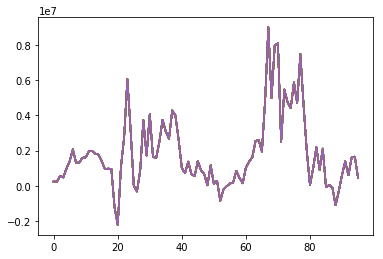

In [16]:
def GridMax( left = -13e6, right = 87e6, num = 10, path_num = 100000):
    delta = (right - left)/(num-1)
    Val = list()
    param = list()
    max_LU = np.zeros(2)
    max_Val = 0
    
    for i in range(num):
        for j in range(i+1,num):
            L = right + i *(delta)
            U = right + j *(delta)
            J = strategy(PC  = sim_power[:path_num],G = sim_gas[:path_num])
            J = np.mean(J[0,:,:])/1000000
            Val.append(J)
            param.append([L,U])
            if J > max_Val:
                max_Val = J
                max_LU = np.array([L,U])
               
            else:
                continue
            print(i,j)
    
    return max_Val, max_LU,Val,param
                
result = GridMax()
#J

In [17]:
print('max_Val: ',result[0])
print('max bound: ',result[1])

max_Val:  48.50682526641219
max bound:  [87000000.        98111111.1111111]


# Dynamic Threshold

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct  4 22:16:36 2019

@author: yuxian
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LinearRegression
import math
from scipy.optimize import minimize
import pandas as pd
import lmfit
import pdb

def L0(x):
    return (np.exp(-x/2)).reshape(-1, 1)
def L1(x):
    return (np.exp(-x/2)*(1-x)).reshape(-1, 1)
def L2(x):
    return (np.exp(-x/2)*(1-2*x+x**2/2)).reshape(-1, 1)


state = np.zeros((20000, 192))
state[(np.arange(20000) % 2) == 1, :] = 1
state[:, 0] = 0

#power = pd.read_csv("Power_Simulation_97.csv", header=None)
#energy = pd.read_csv("Gas_Simulation_97.csv", header=None)
#spark_spread = (power - 12*energy).T.values
power = np.load("power4.npy")
energy = np.load("gas4.npy")
spark_spread = (power - 12*energy).transpose()
spark_spread = np.array([spark_spread[i//2,:] for i in range(20000)])

state = np.zeros((20000, spark_spread.shape[1]-1))
state[(np.arange(20000) % 2) == 1, :] = 1
state[:, 0] = 0


r = 0.05
start_cost = 3 * 1000 * 16 * 7.6
discount = np.exp(-r/48)

def R(ss_t):
    return ss_t * 1000 * 16 * 7.6 - 5 * 1000 * 16 * 7.6


def get_xlist(x):
    return np.concatenate((L0(x), L1(x), L2(x)), axis=1)

def J(para, s0, ss0, ss1, J_delay, opt):
#     return profit of this week + revenue in the future
#    pdb.set_trace()
    if opt:
        upper = para['upper'].value
        lower = para['lower'].value
    else:
        upper, lower = para

    idx_off = s0 == 0
    idx_on = s0 == 1
#    pdb.set_trace()
#    turn_on = idx_off * (ss0 > upper)
#    turn_off = idx_on * (ss0 < lower)

    profit = np.concatenate(([R(ss1)], [R(ss1)]),axis=0).transpose()
    profit[s0==0, 0] = 0
    profit[s0==0, 1] = -start_cost


    a_t = idx_off * (ss0 > upper) + idx_on * (ss0 >= lower)

    X = get_xlist(ss0)

    Y_hat = np.zeros(len(s0))

    if all(s0 == 0):   
        Y_hat[(np.arange(len(s0)) % 2 == 0) & (a_t == 0)] = J_delay[(np.arange(len(s0)) % 2 == 0) & (a_t == 0)] + profit[(np.arange(len(s0)) % 2 == 0) & (a_t == 0), 0]     
        Y_hat[(np.arange(len(s0)) % 2 == 0) & (a_t == 1)] = J_delay[np.arange(len(s0))[(np.arange(len(s0)) % 2 == 0) & (a_t == 1)] + 1]+ profit[(np.arange(len(s0)) % 2 == 0) & (a_t == 1), 1]       
        Y_hat[np.arange(1, len(s0), 2)] = Y_hat[np.arange(0, len(s0), 2)]
        
        
    else:    

        if any((s0==0) & (a_t==0)):
            idx = (s0==0) & (a_t==0)
            Y = discount * (J_delay[np.arange(0, len(s0), 2)][a_t[s0==0]==0] + profit[idx, 0])
            Y_hat[idx] = LinearRegression().fit(X[idx,:], Y).predict(X[idx,:])
        if any((s0==0) & (a_t==1)):
            idx = (s0==0) & (a_t==1)
            Y = discount * (J_delay[np.arange(1, len(s0), 2)][a_t[s0==0]==1] + profit[idx, 1])
            Y_hat[idx] = LinearRegression().fit(X[idx,:], Y).predict(X[idx,:])

        if any((s0==1) & (a_t==0)):
            idx = (s0==1) & (a_t==0)
            Y = discount * (J_delay[np.arange(0, len(s0), 2)][a_t[s0==1]==0] + profit[idx, 0])
            Y_hat[idx] = LinearRegression().fit(X[idx,:], Y).predict(X[idx,:])
        if any((s0==1) & (a_t==1)):
            idx = (s0==1) & (a_t==1)
            Y = discount * (J_delay[np.arange(1, len(s0), 2)][a_t[s0==1]==1] + profit[idx, 1])
            Y_hat[idx] = LinearRegression().fit(X[idx,:], Y).predict(X[idx,:])
#    
#    if not opt:
#        pdb.set_trace()
    return Y_hat

def target(para, s0, ss0, ss1, J_delay, opt):
    return -np.mean(J(para, s0, ss0, ss1, J_delay, opt))

def optimize(state, spark, J_delay=None):
    thres = np.zeros((2, spark.shape[1] - 1))
    value = np.zeros((state.shape))

    for i in range(state.shape[1])[::-1]:
        if J_delay is None:
            J_delay = np.zeros(state.shape[0])
            
        s0 = state[:, i]    
        ss0 = spark[:, i]
        ss1 = spark[:, i+1]
        params = lmfit.Parameters()
        params.add('upper', 5, min=-5, max=15)
        params.add('lower', 0, min=-10, max=10)
        bound_result = lmfit.minimize(target, params, args=(s0, ss0, ss1, J_delay, True), method="brute", Ns=10, workers=-1) 

        thres[:, i] = [bound_result.params['upper'].value, bound_result.params['lower'].value]
        J_delay = J(thres[:, i], s0, ss0, ss1, J_delay, False)
#        pdb.set_trace()
        value[:,i] = J_delay
        
    return thres, value


#thres, value = optimize(state, spark_spread)
    
state = np.zeros((200000, 192))
state[(np.arange(200000) % 2) == 1, :] = 1
state[:, 0] = 0
power = np.load("power4.npy")
energy = np.load("gas4.npy")
spark_spread = (power - 12*energy).transpose()
spark_spread = np.array([spark_spread[i//2,:] for i in range(200000)])

thres4, value4 = optimize(state, spark_spread)
np.save("thres4.npy", thres4)
thres4 = pd.DataFrame(thres4[:,96])
thres4.T.plot()
plt.title("Threshold")
plt.xlabel('Time')
plt.legend(("On", "Off"))
plt.show()



state = np.zeros((200000, 144))
state[(np.arange(200000) % 2) == 1, :] = 1
state[:, 0] = 0
power = np.load("power3.npy")
energy = np.load("gas3.npy")
spark_spread = (power - 12*energy).transpose()
spark_spread = np.array([spark_spread[i//2,:] for i in range(200000)])

thres3, value3 = optimize(state, spark_spread)
np.save("thres3.npy", thres3)
thres3 = pd.DataFrame(thres3[:,96])
thres3.T.plot()
plt.title("Threshold")
plt.xlabel('Time')
plt.legend(("On", "Off"))
plt.show()


state = np.zeros((200000, 96))
state[(np.arange(200000) % 2) == 1, :] = 1
state[:, 0] = 0
power = np.load("power3.npy")
energy = np.load("gas3.npy")
spark_spread = (power - 12*energy).transpose()
spark_spread = np.array([spark_spread[i//2,:] for i in range(200000)])

thres2, value2 = optimize(state, spark_spread)
thres2 = pd.DataFrame(thres2[:,:96])
thres2.T.plot()
plt.title("Threshold")
plt.xlabel('Time')
plt.legend(("On", "Off"))
plt.show()


In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[15]:


import numpy as np
import scipy 
from scipy import stats
from scipy.stats import norm,uniform
import matplotlib.pyplot as plt
import pdb
from GasPower import func1
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import math
from scipy.optimize import minimize
import lmfit


# In[3]:


for i in range (24, 49, 12):
    power, gas = func1(i,random_seed=125)
    np.save("power"+str(int(i/12))+".npy", power)
    np.save("gas"+str(int(i/12))+".npy", gas)


# In[16]:


power, gas = func1(24,random_seed=10)
np.save("power_test.npy", power)
np.save("gas_test.npy", gas)


# In[17]:


def L0(x):
    return (np.exp(-x/2)).reshape(-1, 1)
def L1(x):
    return (np.exp(-x/2)*(1-x)).reshape(-1, 1)
def L2(x):
    return (np.exp(-x/2)*(1-2*x+x**2/2)).reshape(-1, 1)

r = 0.05
start_cost = 3 * 1000 * 16 * 7.6
discount = np.exp(-r/48)

def R(ss_t):
    return ss_t * 1000 * 16 * 7.6 - 5 * 1000 * 16 * 7.6

def get_xlist(x):
    return np.concatenate((L0(x), L1(x), L2(x)), axis=1)

def J(para, s0, ss0, ss1, J_delay, opt):
#     return profit of this week + revenue in the future
#    pdb.set_trace()
    if opt:
        upper = para['upper'].value
        lower = para['lower'].value
    else:
        upper, lower = para

    idx_off = s0 == 0
    idx_on = s0 == 1

    profit = np.concatenate(([R(ss1)], [R(ss1)]),axis=0).transpose()
    profit[s0==0, 0] = 0
    profit[s0==0, 1] = -start_cost


    a_t = idx_off * (ss0 > upper) + idx_on * (ss0 >= lower)

    X = get_xlist(ss0)

    Y_hat = np.zeros(len(s0))

    if all(s0 == 0):   
        Y_hat[(np.arange(len(s0)) % 2 == 0) & (a_t == 0)] = J_delay[(np.arange(len(s0)) % 2 == 0) & (a_t == 0)] + profit[(np.arange(len(s0)) % 2 == 0) & (a_t == 0), 0]     
        Y_hat[(np.arange(len(s0)) % 2 == 0) & (a_t == 1)] = J_delay[np.arange(len(s0))[(np.arange(len(s0)) % 2 == 0) & (a_t == 1)] + 1]+ profit[(np.arange(len(s0)) % 2 == 0) & (a_t == 1), 1]       
        Y_hat[np.arange(1, len(s0), 2)] = Y_hat[np.arange(0, len(s0), 2)]
        
        
    else:    

        if any((s0==0) & (a_t==0)):
            idx = (s0==0) & (a_t==0)
            Y = discount * (J_delay[np.arange(0, len(s0), 2)][a_t[s0==0]==0] + profit[idx, 0])
            Y_hat[idx] = LinearRegression().fit(X[idx,:], Y).predict(X[idx,:])
        if any((s0==0) & (a_t==1)):
            idx = (s0==0) & (a_t==1)
            Y = discount * (J_delay[np.arange(1, len(s0), 2)][a_t[s0==0]==1] + profit[idx, 1])
            Y_hat[idx] = LinearRegression().fit(X[idx,:], Y).predict(X[idx,:])

        if any((s0==1) & (a_t==0)):
            idx = (s0==1) & (a_t==0)
            Y = discount * (J_delay[np.arange(0, len(s0), 2)][a_t[s0==1]==0] + profit[idx, 0])
            Y_hat[idx] = LinearRegression().fit(X[idx,:], Y).predict(X[idx,:])
        if any((s0==1) & (a_t==1)):
            idx = (s0==1) & (a_t==1)
            Y = discount * (J_delay[np.arange(1, len(s0), 2)][a_t[s0==1]==1] + profit[idx, 1])
            Y_hat[idx] = LinearRegression().fit(X[idx,:], Y).predict(X[idx,:])
#    
#    if not opt:
#        pdb.set_trace()
    return Y_hat

def target(para, s0, ss0, ss1, J_delay, opt):
    return -np.mean(J(para, s0, ss0, ss1, J_delay, opt))

def optimize(state, spark, J_delay=None):
    thres = np.zeros((2, spark.shape[1] - 1))
    value = np.zeros((state.shape))

    for i in range(state.shape[1])[::-1]:
        if J_delay is None:
            J_delay = np.zeros(state.shape[0])
            
        s0 = state[:, i]    
        ss0 = spark[:, i]
        ss1 = spark[:, i+1]
        params = lmfit.Parameters()
        params.add('upper', 5, min=-5, max=15)
        params.add('lower', 0, min=-10, max=10)
        bound_result = lmfit.minimize(target, params, args=(s0, ss0, ss1, J_delay, True), method="brute", Ns=10, workers=-1) 

        thres[:, i] = [bound_result.params['upper'].value, bound_result.params['lower'].value]
        J_delay = J(thres[:, i], s0, ss0, ss1, J_delay, False)
#        pdb.set_trace()
        value[:,i] = J_delay
        
    return thres, value


# In[ ]:


#thres, value = optimize(state, spark_spread)
    
state = np.zeros((200000, 192))
state[(np.arange(200000) % 2) == 1, :] = 1
state[:, 0] = 0
power = np.load("power4.npy")
energy = np.load("gas4.npy")
spark_spread = (power - 12*energy)
spark_spread = np.array([spark_spread[i//2,:] for i in range(200000)])

thres4, value4 = optimize(state, spark_spread)
np.save("thres4new.npy", thres4)
print(value4)
thres4 = pd.DataFrame(thres4[:,:96])
thres4.T.plot()
plt.title("Threshold")
plt.xlabel('Time')
plt.legend(("On", "Off"))
plt.show()


state = np.zeros((200000, 144))
state[(np.arange(200000) % 2) == 1, :] = 1
state[:, 0] = 0
power = np.load("power3.npy")
energy = np.load("gas3.npy")
spark_spread = (power - 12*energy)
spark_spread = np.array([spark_spread[i//2,:] for i in range(200000)])

thres3, value3 = optimize(state, spark_spread)
np.save("thres3new.npy", thres3)
print(value3)
thres3 = pd.DataFrame(thres3[:,:96])
thres3.T.plot()
plt.title("Threshold")
plt.xlabel('Time')
plt.legend(("On", "Off"))
plt.show()


state = np.zeros((200000, 96))
state[(np.arange(200000) % 2) == 1, :] = 1
state[:, 0] = 0
power = np.load("power2.npy")
energy = np.load("gas2.npy")
spark_spread = (power - 12*energy)
spark_spread = np.array([spark_spread[i//2,:] for i in range(200000)])

thres2, value2 = optimize(state, spark_spread)
np.save("thres2new.npy", thres2)
print(value2)
thres2 = pd.DataFrame(thres2[:,:96])
thres2.T.plot()
plt.title("Threshold")
plt.xlabel('Time')
plt.legend(("On", "Off"))
plt.show()


# In[ ]:


power = np.load("power3.npy")
gas = np.load("gas3.npy")


# In[18]:


for i in range(2,5):
    thres = np.load('thres'+str(i)+'new.npy')
    thres = pd.DataFrame(thres[:,:96])
    thres.T.plot(color=['b', 'r'])
    plt.title("Threshold " + str(i) +" year")
    plt.xlabel('Time')
    plt.ylabel('Threshold')
    plt.legend(("On Threshold", "Off Threshold"))
    plt.show()


# In[19]:


temp


# In[ ]:




